![Adversarial Inverse Reinforcement Learning for Market Making](.images/title_image.png)

This notebook contains the code for the paper *Adversarial Inverse Reinforcement Learning* [[arxiv](), [ACM]()] published in the proceedings of the [ICAIF'24](https://ai-finance.org/) conference. The full authors list:  Juraj Zelman (Richfox Capital &  ETH Zürich), Martin Stefanik (Richfox Capital &  ETH Zürich), Moritz Weiß (ETH Zürich) and Prof. Dr. Josef Teichmann (ETH Zürich). The links for both affiliations: [Richfox Capital](https://www.richfox.com/) and [ETH Zürich (Dept. of Mathematics)](https://math.ethz.ch/).

The notebook is structured as follows:
- [**Section 1: Limit order book data preprocessing**](#section-1-limit-order-book-data-preprocessing) - In this section, the pricing data are queried, cleaned and additionally preprocessed for the training of the market making agent and backtesting.
- [**Section 2: Pre-generate expert trajectories**](#section-2-pre-generate-expert-trajectories) - In this section, we initialize our custom limit order book environment and pre-generate expert trajectories for the training of the adversarial inverse reinforcement learning agent.
- [**Section 3: Training of the AIRL agent**](#section-3-training-of-the-airl-agent) - This section contains the full training pipeline of the adversarial inverse reinforcement learning agent.
- [**Section 4: Evaluation of the AIRL agent**](#section-4-evaluation-of-the-airl-agent)
- [**Section 5: Backtests**](#section-5-backtests)
- [**Section 6: Backtest visualizations**](#section-6-backtest-visualizations)
- [**Section 7: Appendix (data analysis)**](#section-7-appendix-data-analysis)

Firstly, let's start by importing the necessary libraries and with general setup.

In [2]:
import os
import pickle
import time
from datetime import datetime

import gymnasium as gym
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as th
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data import rollout, serialize
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util.util import make_vec_env
from matplotlib.dates import DateFormatter
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecCheckNan
from stable_baselines3.ppo import MlpPolicy
from tqdm import tqdm

from src.data import download_data, get_list_of_dates_between
from src.lob.backtest_metrics import drawdowns
from src.lob.commissions import BitCommissions
from src.lob.exchange import Exchange
from src.lob.plots import (
    make_drawdown_plot,
    make_plot,
    set_plot_style,
    visualize_backtest,
)
from src.lob.traders import PureMarketMaker, RLMarketMaker
from src.lob.utils import get_lot_size, get_tick_size
from src.rl.environments import LimitOrderBookGym
from src.rl.experts import ExpertPolicy, RandomPolicy
from src.rl.plotting import visualize_airl_train_stats
from src.rl.rewards import NegativeRewardNet
from src.rl.utils import load_model, save_model, send_notification

In [3]:
# Set the style of the plots
set_plot_style()

# Set strict error checking
th.autograd.set_detect_anomaly(True)
np.seterr(all="raise")

# Set device to GPU if available
DEVICE = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Set the (relative) paths to directories
PATH = "data/pricing/"
PATH_MODELS = "data/models"
PATH_ROLLOUTS = "data/rollouts/"
PATH_VOL_DISTR = "data/volume_distributions/"
PATH_AUTOMATED_BACKTESTS = "data/automated_backtests"
PATH_FIGURES = "figures/"

# Ensure directories exist
os.makedirs(PATH, exist_ok=True)
os.makedirs(PATH_MODELS, exist_ok=True)
os.makedirs(PATH_ROLLOUTS, exist_ok=True)
os.makedirs(PATH_VOL_DISTR, exist_ok=True)
os.makedirs(PATH_AUTOMATED_BACKTESTS, exist_ok=True)
os.makedirs(PATH_FIGURES, exist_ok=True)

In [ ]:
# Set printing/plotting options
PRINT = False  # Enable/disable long print outputs
SAVE_FIG = False  # Enable/disable saving of figures
FIG_SIZE = (14, 5)  # Set figure size

# Set custom color codes
COLOR_GREEN, COLOR_RED = "#13961A", "#EB5C14"

In [ ]:
# Seed for the random generator
# SEED = 1
# SEED = 2
# SEED = 3
# SEED = 4
SEED = 5

# Section 1: Limit order book data preprocessing

In this first section, we download and preprocess the limit order book and trades data for the training and testing of the AIRL market making agent.

<font color='orange'>**Remark:**</font> As discussed in the paper, for the research and demonstration of the AIRL algorithm we get the data from the [Crypto Lake](https://crypto-lake.com/) data provider. For the SOL-USD there is data available from the smaller crypto exchange BIT.COM. Note that since the focus of the paper was the demonstration of the new AIRL approach, we only do a simple preprocessing of the data. For a real-world market making application, more sophisticated data preprocessing and live exchange analysis (e.g. real exchange volumes, detection of fake trades, latency measurements, API limits,  etc.) would be necessary and was beyond the scope of the paper.

### 1.1. Data download

Firstly, the limit order book and trade data are downloaded from the [Crypto Lake](https://crypto-lake.com/) data provider.

<font color='orange'>**Remark:**</font> In order to download the data, it is required to have an active [subscription](https://crypto-lake.com/subscribe/) and the associated AWS credentials file.

In [7]:
# Set the parameters
exchange = "BIT.COM"
symbol = "SOL-USDT"
start_date = datetime(2023, 9, 1)
end_date = datetime(2023, 9, 13)

In [8]:
# Generate a list of dates to download
dates = get_list_of_dates_between(start_date, end_date)

In [ ]:
# Query the data
for date in tqdm(dates):
    download_data(date, symbol, exchange, "book", PATH)  # LOB data
    download_data(date, symbol, exchange, "trades", PATH)  # Trade data

### 1.2. Visualize the bid-ask prices

In this subsection, we visualize the bid-ask prices for different limit order book levels. As can be seen from the visualizations below, there are multiple timestamps with wide quoted spreads.

These timestamps are filtered out from the dataset in the next subsection so that the market maker does not profit from these (to be safe we choose the assumption that these were not capturable). This assumption can potentially only worsen the market maker's performance in our backtests. A more detailed analysis would be needed to determine whether such spreads could be captured by the market maker in live trading but this is beyond the scope of the paper.

In [9]:
# Set the parameters
exchange = "BIT.COM"
symbol = "SOL-USDT"
start_date = datetime(2023, 9, 1)
end_date = datetime(2023, 9, 13)

In [10]:
# Load the order book data from parquet files
ob_prefix = f"{exchange}_{symbol}_order_book"

# Generate a list of dates
dates = get_list_of_dates_between(start_date, end_date)

# Create a single joined dataframe with order book data
df_joined = None
for date in dates:
    file_name = f"{ob_prefix}_{date.strftime('%Y_%m_%d')}_original.parquet"
    df = pd.read_parquet(os.path.join(PATH, file_name))
    if df_joined is None:
        df_joined = df
    else:
        df_joined = pd.concat([df_joined, df])

df_joined.sort_index(inplace=True)

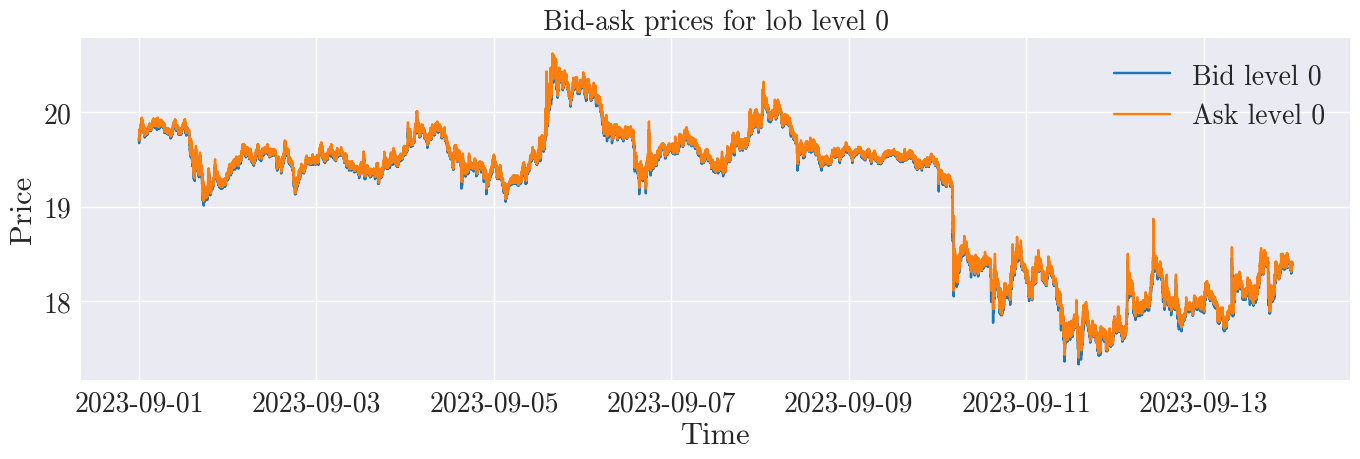

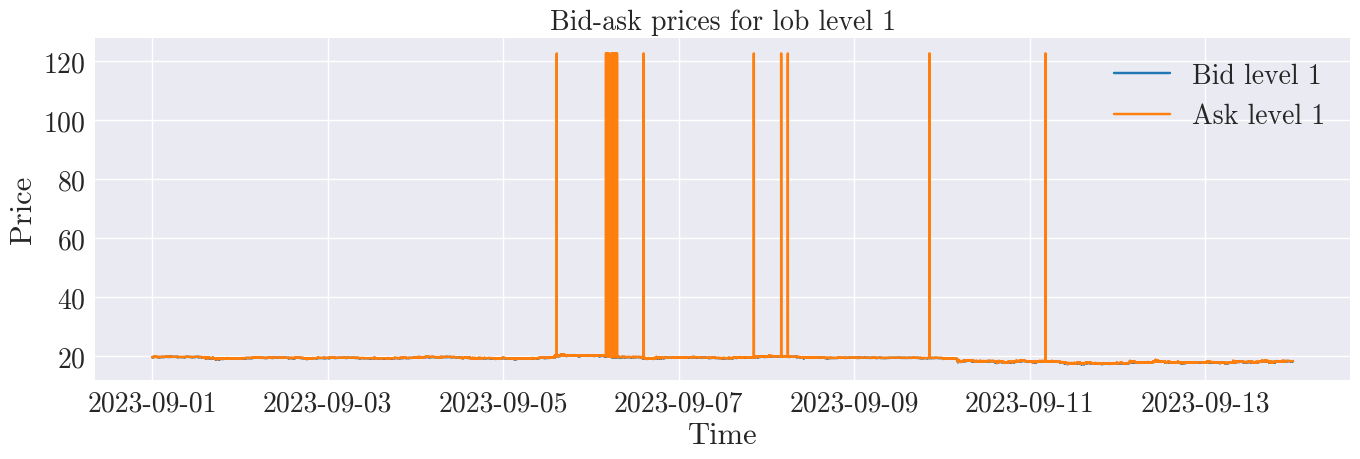

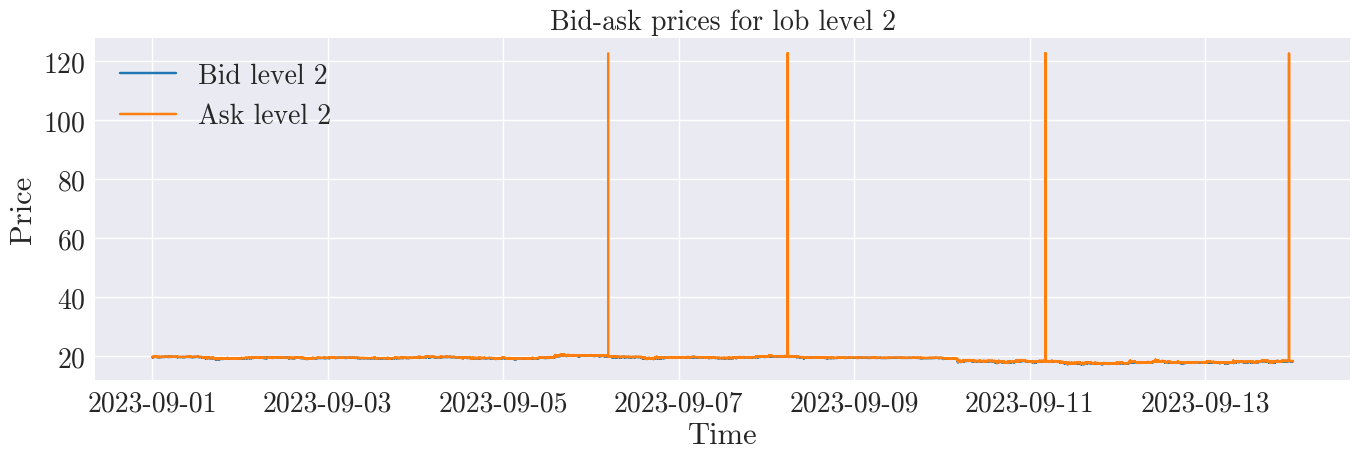

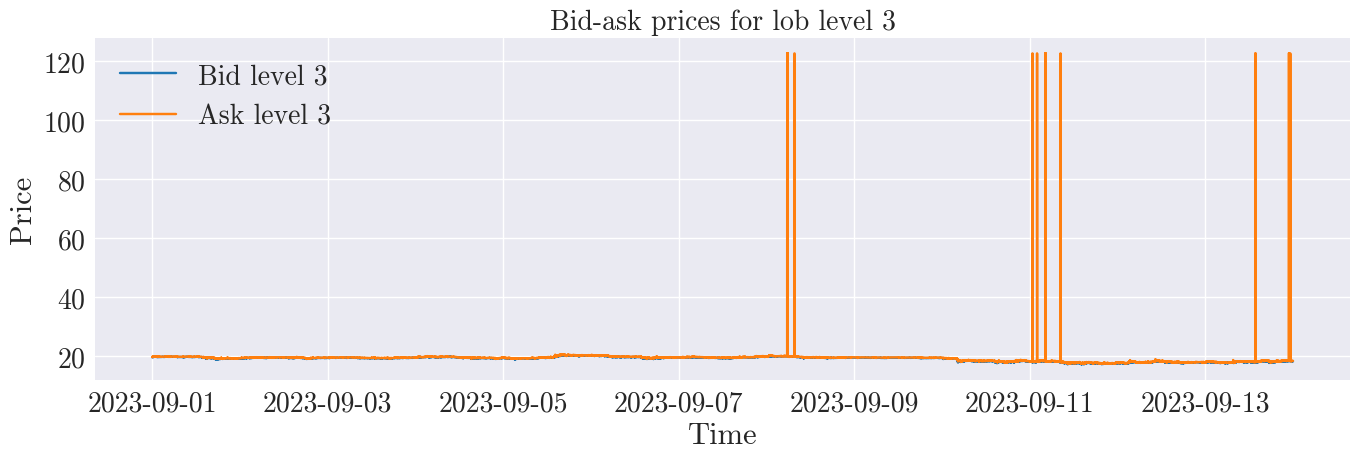

In [11]:
# Visualize the bid-ask prices for each limit order book level
for level in range(4):
    fig = plt.figure(figsize=FIG_SIZE)
    plt.plot(df_joined[f"bid_{level}_price"], label=f"Bid level {level}")
    plt.plot(df_joined[f"ask_{level}_price"], label=f"Ask level {level}")
    plt.title(f"Bid-ask prices for lob level {level}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 1.3. Data cleaning

In the following, we filter out the timestamps with the outlier spreads visualized in the previous section. The number of timestamps filtered for each day is printed below.

Since the focus of the paper is on the market making strategy quoting limit orders, this assumption does not improve the backtest performance as the market making agent does not have the possibility to quote limit orders at the prices with these large spreads.

In [12]:
# Clean and join the pricing dataframes
df_joined = None

for date in dates:
    # Load the dataframe
    file_name = f"{ob_prefix}_{date.strftime('%Y_%m_%d')}_original.parquet"
    df = pd.read_parquet(os.path.join(PATH, file_name))

    # Print the number of rows to be filtered
    threshold = 30
    a = df["ask_0_price"] > threshold
    b = df["ask_1_price"] > threshold
    c = df["ask_2_price"] > threshold
    print(
        f"Date: {date} -",
        f"Rows to be filtered: {df[a | b | c].shape[0]} out of {df.shape[0]}",
        f"({df[a | b | c].shape[0] / df.shape[0] * 100:.2f}%)",
    )

    # Remove outliers
    new_df = df[df["ask_0_price"] < threshold]
    new_df = new_df[new_df["ask_1_price"] < threshold]
    new_df = new_df[new_df["ask_2_price"] < threshold]
    new_df = new_df[new_df["ask_3_price"] < threshold]

    # Save the cleaned dataframe
    new_file_name = f"{ob_prefix}_{date.strftime('%Y_%m_%d')}.parquet"
    new_df.to_parquet(os.path.join(PATH, new_file_name))

    # Join the dataframes
    if df_joined is None:
        df_joined = new_df
    else:
        df_joined = pd.concat([df_joined, new_df])

df_joined.sort_index(inplace=True)

Date: 2023-09-01 00:00:00 - Rows to be filtered: 0 out of 7014 (0.00%)
Date: 2023-09-02 00:00:00 - Rows to be filtered: 0 out of 7577 (0.00%)
Date: 2023-09-03 00:00:00 - Rows to be filtered: 0 out of 6754 (0.00%)
Date: 2023-09-04 00:00:00 - Rows to be filtered: 0 out of 7383 (0.00%)
Date: 2023-09-05 00:00:00 - Rows to be filtered: 1 out of 8767 (0.01%)
Date: 2023-09-06 00:00:00 - Rows to be filtered: 39 out of 8149 (0.48%)
Date: 2023-09-07 00:00:00 - Rows to be filtered: 3 out of 7168 (0.04%)
Date: 2023-09-08 00:00:00 - Rows to be filtered: 231 out of 9118 (2.53%)
Date: 2023-09-09 00:00:00 - Rows to be filtered: 9 out of 6144 (0.15%)
Date: 2023-09-10 00:00:00 - Rows to be filtered: 0 out of 8583 (0.00%)
Date: 2023-09-11 00:00:00 - Rows to be filtered: 39 out of 11291 (0.35%)
Date: 2023-09-12 00:00:00 - Rows to be filtered: 0 out of 10089 (0.00%)
Date: 2023-09-13 00:00:00 - Rows to be filtered: 423 out of 12495 (3.39%)


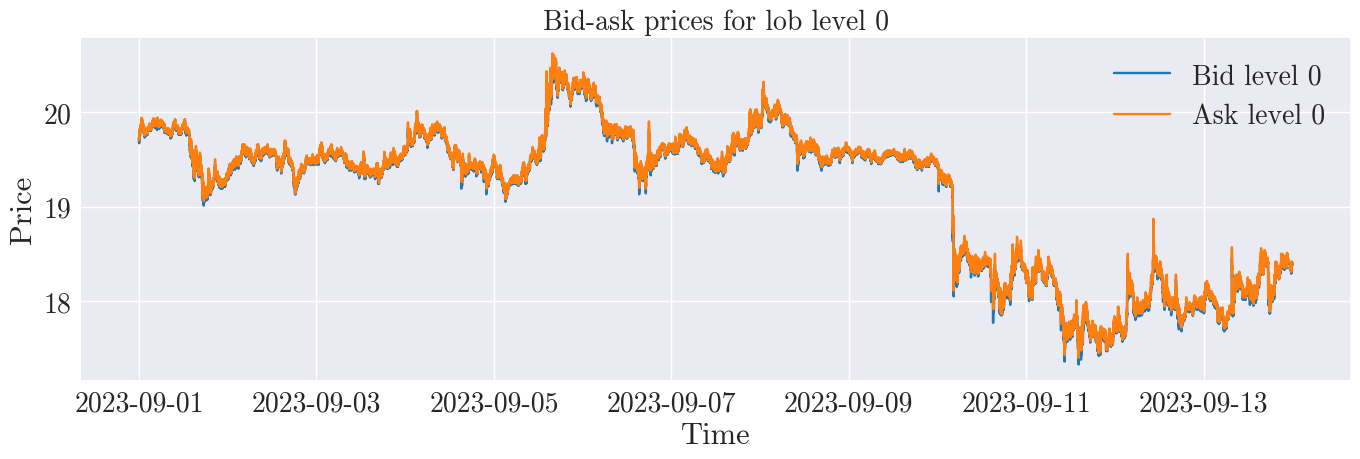

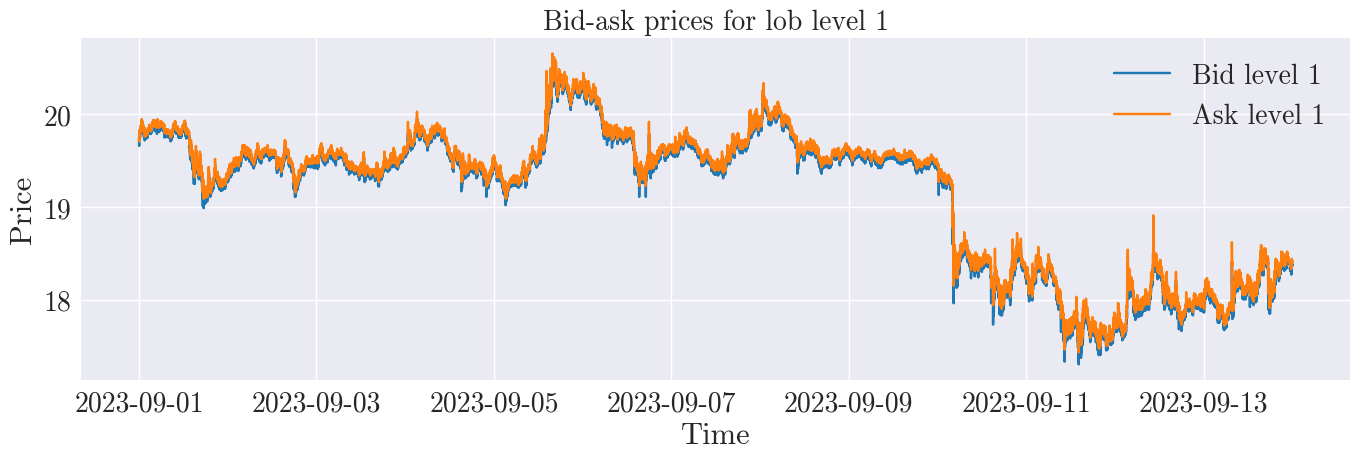

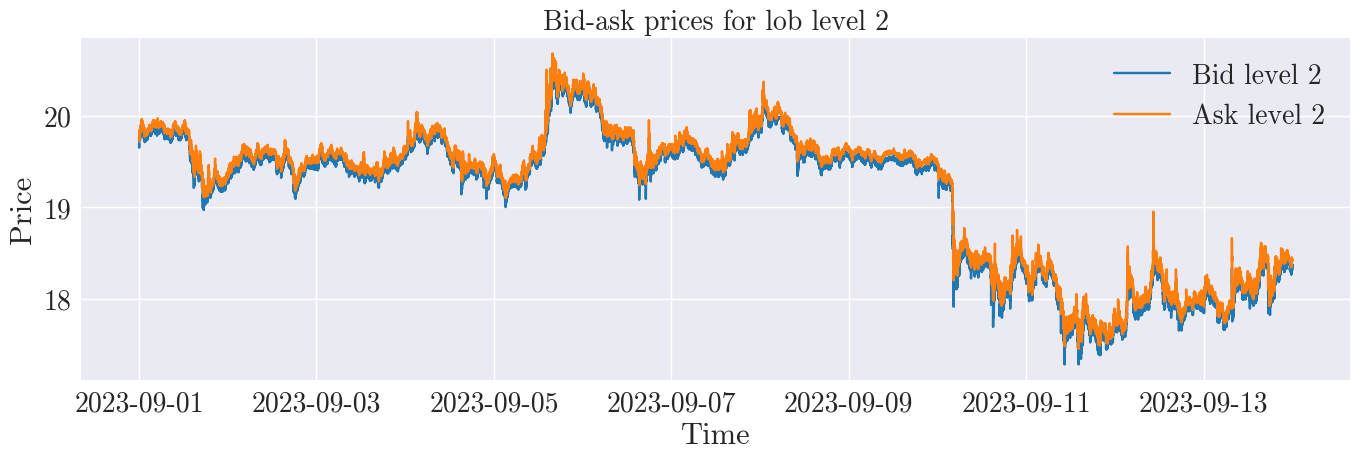

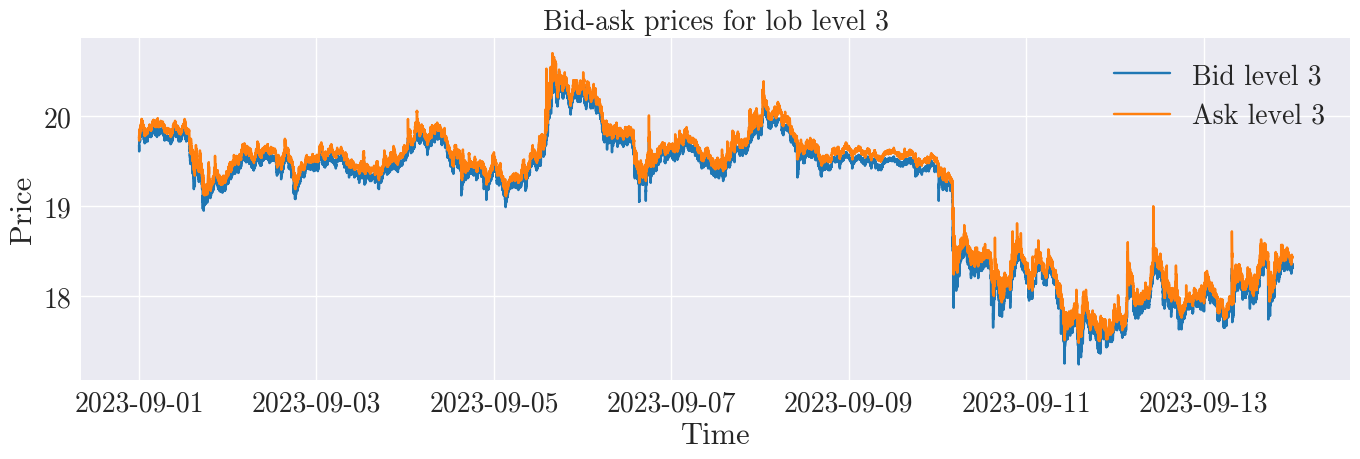

In [13]:
# Visualize the bid-ask prices for each limit order book level (after cleaning)
for level in range(4):
    fig = plt.figure(figsize=(14, 5))
    plt.plot(df_joined[f"bid_{level}_price"], label=f"Bid level {level}")
    plt.plot(df_joined[f"ask_{level}_price"], label=f"Ask level {level}")
    plt.title(f"Bid-ask prices for lob level {level}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

The outlier spreads are now removed from the data and the cleaned data are used for the training of the market making agent.

### 1.3. Generate volume distributions

Here, we generate the empirical volume distributions at each limit order book level. As described in the paper, these empirical volume distributions are used in the stochastic backtest simulator to sample the volumes of the penalizing front-running orders which worsen the priority of the market making agent's orders.

In [14]:
# Set the new dates (Use only insample data for training)
start_date = datetime(2023, 9, 1)
end_date = datetime(2023, 9, 10)

In [15]:
# Ensure the volume distributions directory exists
os.makedirs(PATH_VOL_DISTR, exist_ok=True)

In [16]:
# Load the order book data from parquet files
ob_prefix = f"{exchange}_{symbol}_order_book"

# Generate a list of dates
dates = get_list_of_dates_between(start_date, end_date)

# Create a single joined dataframe with order book data
df_joined = None
for date in dates:
    file_name = f"{ob_prefix}_{date.strftime('%Y_%m_%d')}.parquet"
    df = pd.read_parquet(os.path.join(PATH, file_name))
    if df_joined is None:
        df_joined = df
    else:
        df_joined = pd.concat([df_joined, df])

df_joined.sort_index(inplace=True)

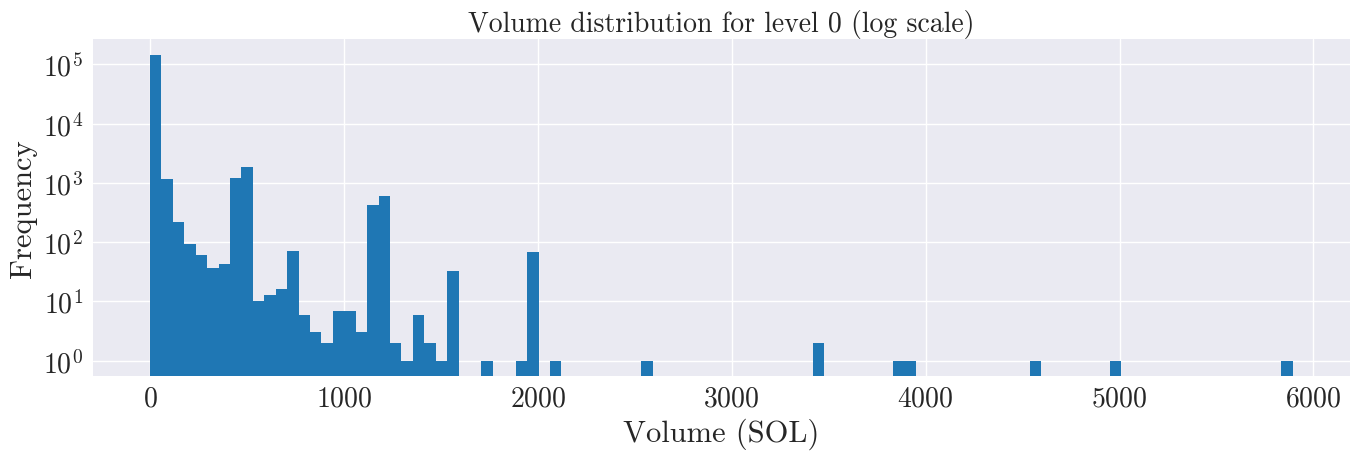

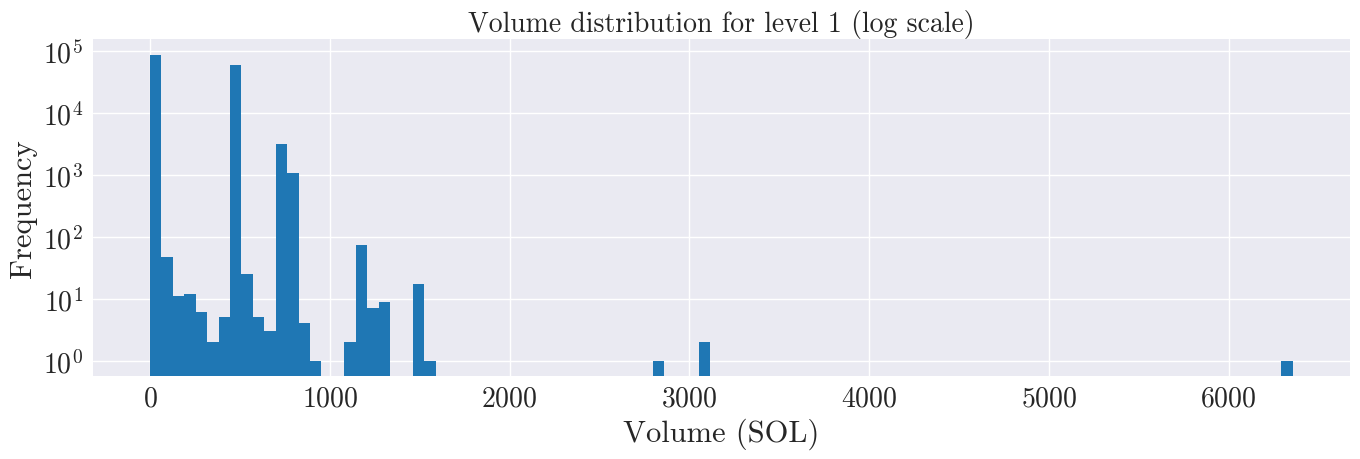

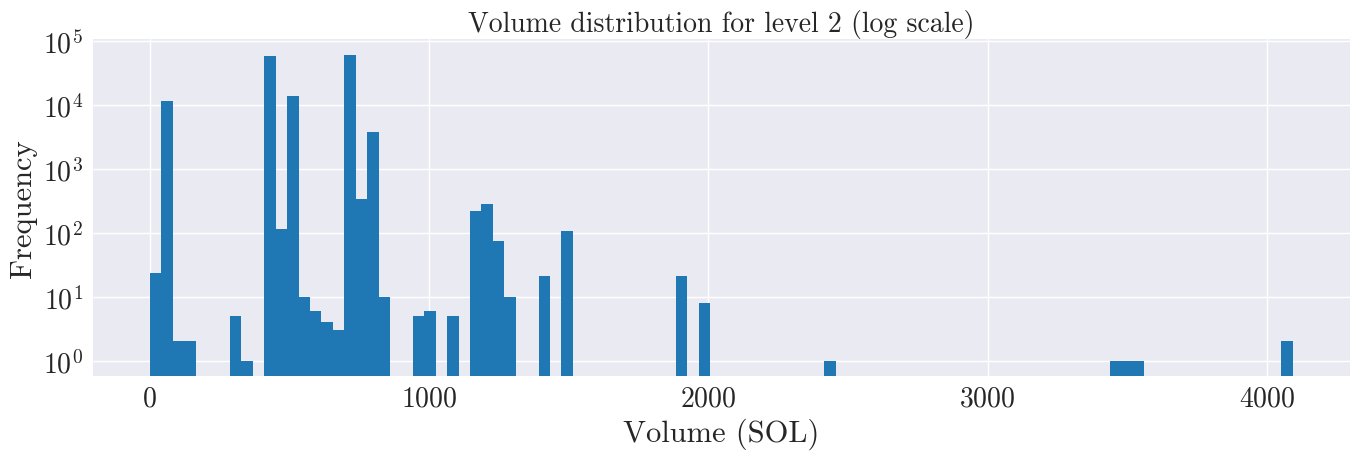

In [17]:
# Visualize the volume distribution for each limit order book level
for level in range(3):
    # Join the bid and ask volumes
    vols_level = list(df_joined[f"bid_{level}_size"].values) + list(
        df_joined[f"ask_{level}_size"].values
    )

    # Visualize the volume distribution
    fig = plt.figure(figsize=FIG_SIZE)
    plt.hist(vols_level, bins=100, log=True)
    plt.xlabel("Volume (SOL)")
    plt.ylabel("Frequency")
    plt.title(f"Volume distribution for level {level} (log scale)")
    plt.tight_layout()
    plt.show()

In [18]:
# Generate and save the volume distributions. This distributions are later
# loaded and sampled from in the stochastical backtests.
for level in range(3):
    # Join the bid and ask volumes
    vols_level = pd.Series(
        list(df_joined[f"bid_{level}_size"].values)
        + list(df_joined[f"ask_{level}_size"].values)
    )

    # Save the volume distribution
    file_path = os.path.join(PATH_VOL_DISTR, f"volumes_level_{level}.pkl")
    vols_level.to_pickle(file_path)

# Section 2: Pre-generate expert trajectories

In the second section, we pre-generate the expert trajectories using the previously downloaded limit order book data. The expert trajectories are generated by simulating the expert-like market making agent's actions in the backtest simulator. These expert trajectories are later used in the adversarial inverse reinforcement learning algorithm to train the discriminator (or reward neural network) for distinguishing the expert trajectories from the adversarial agent's trajectories.

### 2.1. Register custom vectorized environment

Firstly, we need to load and register our custom limit order book environment as a custom gym vectorized environment. This is necessary for the [stable-baselines3](https://stable-baselines3.readthedocs.io/en/master/) library to work with the environment. This environment was implemented as a part of the paper and can be found in the [`src/lob`](./src/lob/) module and [`src/rl/environments.py`](./src/rl/environments.py) file.

In [19]:
# Set the parameters
EXCHANGE_NAME = "BIT.COM"
SYMBOL = "SOL-USDT"
TICK_SIZE = get_tick_size(EXCHANGE_NAME)  # Tick size of the limit order book
LOT_SIZE = get_lot_size(EXCHANGE_NAME)  # Lot size of the limit order book
DEPTH = 20  # Depth of the data to load to the limit order book (max 20)
EXCHANGE_TRADER_ID = "Exchange"
MAX_STEPS = 300  # Maximum number of steps in an episode
TS_START = pd.Timestamp("2023-09-01 00:00:00")  # Start of the episode
TS_END = pd.Timestamp("2023-09-10 23:59:59")  # End of the episode
DETERMINISTIC = False  # Indicates whether to use a deterministic environment
WIN = 0  # Window size for the features computation
LOGGING = False  # Indicates whether to log events
TS_SAVE = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Ts for model saving
LATENCY_COMP_PARAMS = {}  # Parameters for the stochastic backtest
RNG = np.random.default_rng(seed=SEED)  # Random number generator
traders = {}  # Dictionary of traders

print("Timestamp for saving: ", TS_SAVE)

Timestamp for saving:  2024-11-06_23-52-10


In [20]:
# Set the parameters for the RL agent
rl_trader_id = "RLMarketMaker"
com_model = BitCommissions(tier=5)
volume = 100

# Initialize the trader
trader = RLMarketMaker(
    id=rl_trader_id,
    com_model=com_model,
    volume=volume,
)
traders[rl_trader_id] = trader

# Write a description of the experiment
description = "RL market maker simulation."

In [21]:
# Set the parameters for the limit order book environment
ID = "LimitOrderBookGym-v1"
ENTRY_POINT = LimitOrderBookGym
KWARGS = {
    "exchange_name": EXCHANGE_NAME,
    "symbol_name": SYMBOL,
    "tick_size": TICK_SIZE,
    "lot_size": LOT_SIZE,
    "depth": DEPTH,
    "traders": traders,
    "max_steps": MAX_STEPS,
    "ts_start": TS_START,
    "ts_end": TS_END,
    "deterministic": DETERMINISTIC,
    "win": WIN,
    "path": PATH,
    "path_vol_distr": PATH_VOL_DISTR,
    "rl_trader_id": rl_trader_id,
    "latency_comp_params": LATENCY_COMP_PARAMS,
    "logging": LOGGING,
    "ts_save": TS_SAVE,
    "description": description,
    "rng": RNG,
}

# Register the environment
gym.envs.register(
    id=ID,
    entry_point=ENTRY_POINT,
    kwargs=KWARGS,
    max_episode_steps=MAX_STEPS,
)

# Create the environment
env = Monitor(gym.make(ID))

# Save the saving ts
ts_save = env.unwrapped.exchange.ts_save

In [22]:
# Initialize the vectorized environment
venv = make_vec_env(
    ID,
    rng=RNG,
    n_envs=1,
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],  # needed for computing rollouts later
    parallel=False,
)
venv = VecCheckNan(venv, raise_exception=True)  # Check for NaN observations
venv.reset()

array([[ 0.        , -0.12269539, -0.11015325, -0.12057227,  0.12269539,
         0.14253393,  0.15313317,  0.        ,  0.        , -0.9782609 ,
        -0.2016129 , -0.06666667]], dtype=float32)

### 2.2. Generate rollouts with random and expert policies

Next, we define an expert policy that will be used as a target for the adversarial agent. We use this expert policy to generate the expert trajectories for the AIRL algorithm. These trajectories are saved to the `data/rollouts` directory and loaded before training to save time in the training process. Alternatively, you can also generate these during the AIRL training process but this will take more time.

In [23]:
# Set the parameters for the rollout
min_timesteps = None
min_episodes = 1

# Rollout the environment with a random policy
rollouts = rollout.rollout(
    None,  # Random policy
    venv,
    sample_until=rollout.make_sample_until(
        min_timesteps=min_timesteps, min_episodes=min_episodes
    ),
    rng=RNG,
)

# Print the first rollout
if PRINT:
    for i in range(len(rollouts[0].obs) - 1):
        print("Observation: ", rollouts[0].obs[i])
        print("Action: ", rollouts[0].acts[i])
        print()

In [24]:
# Initialize the random policy
random_policy = RandomPolicy(venv.action_space)

# Evaluate the random policy
reward_random_policy, _ = evaluate_policy(
    random_policy, env, 1, return_episode_rewards=True
)
print("Reward of the random policy")
print("Reward: ", np.mean(reward_random_policy))
print("Std:    ", np.std(reward_random_policy))

Reward of the random policy
Reward:  18.0
Std:     0.0


In [25]:
# Initialize the expert policy
expert = ExpertPolicy()

# Set the parameters for the rollout
min_timesteps = None
min_episodes = 1

# Rollout the environment with the expert policy
rollouts = rollout.rollout(
    expert.predict,
    venv,
    sample_until=rollout.make_sample_until(
        min_timesteps=min_timesteps, min_episodes=min_episodes
    ),
    rng=RNG,
)

# Print the first rollout
if PRINT:
    for i in range(len(rollouts[0].obs) - 1):
        state, act = rollouts[0].obs[i][0], rollouts[0].acts[i]
        print(f"State 0: {state: .3f} --> Action: {act}")

In [26]:
# Flatten the trajectories into transitions
transitions = rollout.flatten_trajectories(rollouts)
if PRINT:
    print("Transitions: ", transitions)

In [27]:
# Evaluate the expert
reward_expert_policy, _ = evaluate_policy(
    expert, venv, 1, return_episode_rewards=True
)
print("Perfect reward of the expert policy")
print("Reward: ", np.mean(reward_expert_policy))
print("Std:    ", np.std(reward_expert_policy))

Perfect reward of the expert policy
Reward:  300.0
Std:     0.0


In [28]:
# Generate or load presaved sample of expert trajectories.
# These rollouts are later used to train the AIRL agent, in particular they are
# used to train its discriminator.
rollouts_file = os.path.join(PATH_ROLLOUTS, "rollouts.pkl")

# If the presaved rollouts file exists load the rollouts
if os.path.exists(rollouts_file):
    rollouts = serialize.load(rollouts_file)

# Else, generate the rollouts and save them for future use
else:
    # Set the parameters for the rollout
    min_timesteps = 45000 * 3 + 4500
    min_episodes = None

    # Rollout the environment with the expert policy
    print("Generating rollouts... (Might take around 15 minutes.)")
    rollouts = rollout.rollout(
        expert.predict,
        venv,
        sample_until=rollout.make_sample_until(
            min_timesteps=min_timesteps, min_episodes=min_episodes
        ),
        rng=RNG,
    )

    # Ensure the directory exists and save the rollouts
    serialize.save(rollouts_file, rollouts)

# Print the first rollout
if PRINT:
    for i in range(len(rollouts[0].obs) - 1):
        print("Observation: ", rollouts[0].obs[i])
        print("Action: ", rollouts[0].acts[i])
        print()

# Section 3: Training of the AIRL agent

This section demonstrates a pipeline for training of the adversarial inverse reinforcement learning agent. The goal is to learn the reward function of the expert policy by training of the discriminator network and the agent policy network (PPO).

### 3.1. Initialize the AIRL agent

In this subsection, we set the hyperparameters for the [PPO algorithm](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html) and the AIRL discriminator ([reward neural network](https://imitation.readthedocs.io/en/latest/main-concepts/reward_networks.html)).

In [29]:
# Set parameters for the PPO algorithm (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 10  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the current reward
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

In [ ]:
# Set parameters for the (negative) reward net
use_state = True  # Current state is used for the reward
use_action = True  # Current action is used for the reward
use_next_state = False  # Next state is used for the reward
use_done = False  # Done flag is used for the reward

In [31]:
# Set parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing the issue with the NaNs

<font color='orange'>**Warning:**</font> Be careful when updating the settings below. When changing them, use the multiples of episode length (otherwise you might run into unexpected issues with variable horizons during training).

In [ ]:
# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 600

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [33]:
# Initialize the learner PPO policy (generator)
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=SEED,
    device=DEVICE,
)

In [34]:
# Initialize the custom reward network (discriminator)
reward_net = NegativeRewardNet(
    observation_space=venv.observation_space,
    action_space=venv.action_space,
    use_state=use_state,
    use_action=use_action,
    use_next_state=use_next_state,
    use_done=use_done,
)

In [35]:
# Initialize the AIRL trainer
airl_trainer = AIRL(
    demonstrations=rollouts,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [37]:
# Evaluate the PPO policy before training
venv.seed(SEED)
learner_rewards_before_training, _ = evaluate_policy(
    learner, venv, 1, return_episode_rewards=True
)
print("Mean: ", np.mean(learner_rewards_before_training))
print("Std: ", np.std(learner_rewards_before_training))

Mean:  4.0
Std:  0.0


In [38]:
# Visualize actions of the PPO policy before training
if PRINT:
    for _ in range(1):
        obs = venv.reset()
        done = False
        while not done:
            print(obs)
            action, _ = learner.predict(obs, deterministic=True)
            print(action)
            print()
            obs, _, done, _ = venv.step(action)

### 3.2. Train the AIRL agent

Finally, here we train the adversarial inverse reinforcement learning agent. The training process iterates between two steps:
1. **Discriminator training** - Train the discriminator (reward neural network) to distinguish between the expert and adversarial agent's trajectories.
2. **PPO training** - Train the PPO agent to maximize the reward from the discriminator.

The training process is repeated for the specified number of iterations (implied by the total number of steps and number of steps for training of the generator).

In [ ]:
# Train the AIRL agent
airl_trainer.train(total_timesteps=total_timesteps)

### 3.3. Save the trained model and training statistics

Lastly, save the trained model and the training statistics for further analysis and backtesting.

In [ ]:
# Save the model
ts = airl_trainer.ts_now
stats = airl_trainer.logger._logger.stats
save_model(learner, reward_net, stats, PATH_MODELS, ts)
print(f"Saved the model with timestamp: {ts}")

# Section 4: Evaluation of the AIRL agent

### 4.1. Load the trained model

In [ ]:
# Pick the timestamp of the model to load
# ts = "2024-01-21_17-12-35" # seed 1
# ts = "2024-01-22_18-03-01" # seed 2
# ts = "2024-01-23_19-14-27" # seed 3
# ts = "2024-01-24_09-40-47" # seed 4
ts = "2024-01-24_22-39-37"  # seed 5

In [ ]:
# Load the model from the new path
learner, reward_net, stats = load_model(PATH_MODELS, ts)

### 4.2. Evaluate the trained model

In [ ]:
# Visualize the stats
visualize_airl_train_stats(stats, save_fig=SAVE_FIG)

In [ ]:
# Evaluate the policy after training
venv.seed(SEED)
learner_rewards_after_training, _ = evaluate_policy(
    learner, venv, 5, return_episode_rewards=True
)
print("Mean: ", np.mean(learner_rewards_after_training))
print("Std: ", np.std(learner_rewards_after_training))

In [ ]:
# Visualize actions of the policy after training
if PRINT:
    for _ in range(1):
        obs = venv.reset()
        done = False
        while not done:
            action, _ = learner.predict(obs, deterministic=True)
            print(f"Obs: {obs[0][0]: .5f} --> Action: {action}")
            obs, _, done, _ = venv.step(action)

### 4.3. Visualize the backtest results

In [ ]:
# Set the parameters
EXCHANGE_NAME = "BIT.COM"
SYMBOL = "SOL-USDT"
TICK_SIZE = get_tick_size(EXCHANGE_NAME)  # Tick size of the limit order book
LOT_SIZE = get_lot_size(EXCHANGE_NAME)  # Lot size of the limit order book
DEPTH = 20  # Depth of the data to load to the limit order book (max 20)
EXCHANGE_TRADER_ID = "Exchange"
MAX_STEPS = None  # Maximum number of steps in an episode
TS_START = pd.Timestamp("2023-09-11 00:00:00")  # Start of the episode
TS_END = pd.Timestamp("2023-09-13 23:59:59")  # End of the episode
WIN = 0  # Window size for the features computation
LOGGING = False  # Indicates whether to log events
LATENCY_COMP_PARAMS = {
    0: {"prob": 0.9, "divisor": 1},
    1: {"prob": 0.9, "divisor": 1},
    2: {"prob": 0.9, "divisor": 1},
    3: {"prob": 0.9, "divisor": 1},
}  # Latency compensation parameters for the stochastic backtest
RNG = np.random.default_rng(seed=SEED)  # Random number generator

In [ ]:
# Initialize the limit order book and traders
start = time.time()
traders = {}

# Behavior cloning agent
rl_trader_id = "RLMarketMaker"
com_model = BitCommissions(tier=5)
volume = 100
trader = RLMarketMaker(
    id=rl_trader_id,
    com_model=com_model,
    volume=volume,
    policy=learner.policy,
)
traders[rl_trader_id] = trader

description = "AIRL agent."

# Initialize the exchange
exchange = Exchange(
    exchange_name=EXCHANGE_NAME,
    symbol_name=SYMBOL,
    tick_size=TICK_SIZE,
    lot_size=LOT_SIZE,
    depth=DEPTH,
    traders=traders,
    max_steps=MAX_STEPS,
    ts_start=TS_START,
    ts_end=TS_END,
    win=WIN,
    path=PATH,
    path_vol_distr=PATH_VOL_DISTR,
    rl_trader_id=rl_trader_id,
    latency_comp_params=LATENCY_COMP_PARAMS,
    logging=LOGGING,
    ts_save=TS_SAVE,
    description=description,
    rng=RNG,
)
end = round(time.time() - start, 2)
print(f"Time taken for initialization of the exchange: {end} sec.")

# Run the exchange simulation
start = time.time()
exchange.run()
end = round(time.time() - start, 2)
print(f"Time taken for running the exchange: {end} sec.")

In [ ]:
# Visualize the backtest results
timestamps = exchange.stats["ts"]
trader_stats = traders[rl_trader_id].stats
initial_cost = 20.5 * volume * 2
visualize_backtest(timestamps, trader_stats, initial_cost)

# Section 5: Backtests

In [ ]:
# TODO: Not needed?
# # Configure Polars
# cfg = pl.Config()
# cfg.set_tbl_rows(20)

### Pure market makers (with different priorities)

In this section I generate the statistics of the pure market making strategy with multiple priorities.

In [ ]:
TS_START = pd.Timestamp("2023-09-01 00:00:00")  # Start of the episode
TS_END = pd.Timestamp("2023-09-13 23:59:59")  # End of the episode

In [ ]:
# Set the parameters
EXCHANGE_NAME = "BIT.COM"
SYMBOL = "SOL-USDT"
TICK_SIZE = get_tick_size(EXCHANGE_NAME)  # Tick size of the limit order book
LOT_SIZE = get_lot_size(EXCHANGE_NAME)  # Lot size of the limit order book
DEPTH = 20  # Depth of the data to load to the limit order book (max 20)
EXCHANGE_TRADER_ID = "Exchange"
MAX_STEPS = None  # Maximum number of steps in an episode
WIN = 0  # Window size for the features computation
# LOGGING = False # Indicates whether to log events
LOGGING = True
TS_SAVE = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Ts for model saving
RNG = np.random.default_rng(seed=SEED)  # Random number generator

# Set the parameters for the stochastic backtest
LATENCY_COMP_PARAMS = {
    0: {"prob": 0.9, "divisor": 1},
    1: {"prob": 0.9, "divisor": 1},
    2: {"prob": 0.9, "divisor": 1},
    3: {"prob": 0.9, "divisor": 1},
}  # Latency compensation parameters for the stochastic backtest

In [ ]:
# Set the parameters for the automated backtest
priorities = [0, 1, 2, 3]
volumes = [100]

In [ ]:
# Initialize the results dictionary
results = {}

# Run the backtests
for priority in priorities:
    for volume in volumes:
        # Initialize the limit order book and traders
        start = time.time()
        traders = {}

        # Pure market making strategy
        trader_id = f"PMM_prior_{priority}_vol_{volume}"
        inventory_manage = True
        description = (
            f"Pure market maker with priority {priority} and volume {volume}."
        )

        # Set the commission model
        if volume == 100:
            if priority == 0:
                tier = 5
            elif priority == 1:
                tier = 5
            elif priority == 2:
                tier = 2
            elif priority == 3:
                tier = 1
        elif volume == 10:
            if priority == 0:
                tier = 4
            elif priority == 1:
                tier = 3
            elif priority == 2:
                tier = 1
            elif priority == 3:
                tier = 1

        com_model = BitCommissions(tier=tier)
        trader = PureMarketMaker(
            trader_id,
            com_model=com_model,
            volume=volume,
            priority=priority,
            inventory_manage=inventory_manage,
        )
        traders[trader.id] = trader

        # Initialize the exchange
        exchange = Exchange(
            exchange_name=EXCHANGE_NAME,
            symbol_name=SYMBOL,
            tick_size=TICK_SIZE,
            lot_size=LOT_SIZE,
            depth=DEPTH,
            traders=traders,
            max_steps=MAX_STEPS,
            ts_start=TS_START,
            ts_end=TS_END,
            win=WIN,
            path=PATH,
            path_vol_distr=PATH_VOL_DISTR,
            rl_trader_id="",
            latency_comp_params=LATENCY_COMP_PARAMS,
            logging=LOGGING,
            ts_save=TS_SAVE,
            description=description,
            rng=RNG,
        )
        end = round(time.time() - start, 2)

        # Run the exchange simulation
        start = time.time()
        exchange.run()
        end = round(time.time() - start, 2)

        # Save the results
        timestamps = exchange.stats["ts"]
        trader_stats = traders[trader_id].stats
        initial_cost = 20.5 * volume * 2
        results[trader_id] = {
            "timestamps": timestamps,
            "trader_stats": trader_stats,
            "initial_cost": initial_cost,
        }

send_notification(message="Backtest finished!", time=20000)

In [ ]:
# Save the results to a pickle file
file_path = os.path.join(PATH_AUTOMATED_BACKTESTS, f"results_{TS_SAVE}.pickle")
with open(file_path, "wb") as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Results saved to {file_path}.")

### Pure market maker (50 seeds)

In this section I generate the statistics of the pure market making strategy with multiple priorities.

In [ ]:
TS_START = pd.Timestamp("2023-09-11 00:00:00")  # Start of the episode
TS_END = pd.Timestamp("2023-09-13 23:59:59")  # End of the episode

In [ ]:
# Set the parameters
EXCHANGE_NAME = "BIT.COM"
SYMBOL = "SOL-USDT"
TICK_SIZE = get_tick_size(EXCHANGE_NAME)  # Tick size of the limit order book
LOT_SIZE = get_lot_size(EXCHANGE_NAME)  # Lot size of the limit order book
DEPTH = 20  # Depth of the data to load to the limit order book (max 20)
EXCHANGE_TRADER_ID = "Exchange"
MAX_STEPS = None  # Maximum number of steps in an episode
WIN = 0  # Window size for the features computation
# LOGGING = False # Indicates whether to log events
LOGGING = False
TS_SAVE = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Ts for model saving


# Set the parameters for the stochastic backtest
LATENCY_COMP_PARAMS = {
    0: {"prob": 0.9, "divisor": 1},
    1: {"prob": 0.9, "divisor": 1},
    2: {"prob": 0.9, "divisor": 1},
    3: {"prob": 0.9, "divisor": 1},
}  # Latency compensation parameters for the stochastic backtest

In [ ]:
# Set the parameters for the automated backtest
priorities = [1]
volumes = [100]

In [ ]:
# Initialize the results dictionary
results = {}

# Run the backtests
for seed in range(1, 51):
    for priority in priorities:
        for volume in volumes:
            RNG = np.random.default_rng(seed=seed)

            # Initialize the limit order book and traders
            start = time.time()
            traders = {}

            # Pure market making strategy
            trader_id = f"PMM_prior_{priority}_vol_{volume}_{seed}"
            inventory_manage = True
            description = (
                f"Pure market maker with priority {priority} and volume ",
                f"{volume}.",
            )

            # Set the commission model
            if volume == 100:
                if priority == 0:
                    tier = 5
                elif priority == 1:
                    tier = 5
                elif priority == 2:
                    tier = 2
                elif priority == 3:
                    tier = 1
            elif volume == 10:
                if priority == 0:
                    tier = 4
                elif priority == 1:
                    tier = 3
                elif priority == 2:
                    tier = 1
                elif priority == 3:
                    tier = 1

            com_model = BitCommissions(tier=tier)
            trader = PureMarketMaker(
                trader_id,
                com_model=com_model,
                volume=volume,
                priority=priority,
                inventory_manage=inventory_manage,
            )
            traders[trader.id] = trader

            # Initialize the exchange
            exchange = Exchange(
                exchange_name=EXCHANGE_NAME,
                symbol_name=SYMBOL,
                tick_size=TICK_SIZE,
                lot_size=LOT_SIZE,
                depth=DEPTH,
                traders=traders,
                max_steps=MAX_STEPS,
                ts_start=TS_START,
                ts_end=TS_END,
                win=WIN,
                path=PATH,
                path_vol_distr=PATH_VOL_DISTR,
                rl_trader_id="",
                latency_comp_params=LATENCY_COMP_PARAMS,
                logging=LOGGING,
                ts_save=TS_SAVE,
                description=description,
                rng=RNG,
            )
            end = round(time.time() - start, 2)

            # Run the exchange simulation
            start = time.time()
            exchange.run()
            end = round(time.time() - start, 2)

            # Save the results
            timestamps = exchange.stats["ts"]
            trader_stats = traders[trader_id].stats
            initial_cost = 20.5 * volume * 2
            results[trader_id] = {
                "timestamps": timestamps,
                "trader_stats": trader_stats,
                "initial_cost": initial_cost,
            }

send_notification(message="Backtest finished!", time=20000)

In [ ]:
# Save the results to a pickle file
file_path = os.path.join(PATH_AUTOMATED_BACKTESTS, f"results_{TS_SAVE}.pickle")
with open(file_path, "wb") as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Results saved to {file_path}.")

### AIRL market maker (50 seeds)

In this section I generate the statistics of the AIRL market making strategy with multiple priorities.

In [ ]:
TS_START = pd.Timestamp("2023-09-11 00:00:00")  # Start of the episode
TS_END = pd.Timestamp("2023-09-13 23:59:59")  # End of the episode

In [ ]:
# Set the parameters
EXCHANGE_NAME = "BIT.COM"
SYMBOL = "SOL-USDT"
TICK_SIZE = get_tick_size(EXCHANGE_NAME)  # Tick size of the limit order book
LOT_SIZE = get_lot_size(EXCHANGE_NAME)  # Lot size of the limit order book
DEPTH = 20  # Depth of the data to load to the limit order book (max 20)
EXCHANGE_TRADER_ID = "Exchange"
MAX_STEPS = None  # Maximum number of steps in an episode
WIN = 0  # Window size for the features computation
# LOGGING = False # Indicates whether to log events
LOGGING = False
TS_SAVE = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Ts for model saving

# Set the parameters for the stochastic backtest
LATENCY_COMP_PARAMS = {
    0: {"prob": 0.9, "divisor": 1},
    1: {"prob": 0.9, "divisor": 1},
    2: {"prob": 0.9, "divisor": 1},
    3: {"prob": 0.9, "divisor": 1},
}  # Latency compensation parameters for stochastic backtest

In [ ]:
# Set the parameters for the automated backtest
priorities = [1]
volumes = [100]

In [ ]:
# Initialize the results dictionary
results = {}

In [ ]:
# Pick the timestamp of the model to load
# ts = "2024-01-21_17-12-35" # seed 1
# ts = "2024-01-22_18-03-01" # seed 2
# ts = "2024-01-23_19-14-27" # seed 3
# ts = "2024-01-24_09-40-47" # seed 4
# ts = "2024-01-24_22-39-37" # seed 5
ts = "2024-01-24_22-39-37_best_9_297.5"  # seed 5 (best model)

In [ ]:
# Load the model)
learner, reward_net, stats = load_model(PATH_MODELS, ts)
print(f"Loaded model for timestamp: {ts}")

In [ ]:
for seed in range(1, 51):
    for priority in priorities:
        for volume in volumes:
            RNG = np.random.default_rng(seed=seed)

            # Initialize the limit order book and traders
            start = time.time()
            traders = {}

            # # Pure market making strategy
            trader_id = f"RL_prior_{priority}_vol_{volume}_{seed}"
            # inventory_manage = True
            description = (
                f"RL market maker with priority {priority} and volume {volume}."
            )

            # Set the commission model
            if volume == 100:
                if priority == 0:
                    tier = 5
                elif priority == 1:
                    tier = 5
                elif priority == 2:
                    tier = 2
                elif priority == 3:
                    tier = 1
            elif volume == 10:
                if priority == 0:
                    tier = 4
                elif priority == 1:
                    tier = 3
                elif priority == 2:
                    tier = 1
                elif priority == 3:
                    tier = 1

            com_model = BitCommissions(tier=tier)
            trader = RLMarketMaker(
                id=trader_id,
                com_model=com_model,
                volume=volume,
                policy=learner.policy,
            )
            traders[trader.id] = trader

            # Initialize the exchange
            exchange = Exchange(
                exchange_name=EXCHANGE_NAME,
                symbol_name=SYMBOL,
                tick_size=TICK_SIZE,
                lot_size=LOT_SIZE,
                depth=DEPTH,
                traders=traders,
                max_steps=MAX_STEPS,
                ts_start=TS_START,
                ts_end=TS_END,
                win=WIN,
                path=PATH,
                path_vol_distr=PATH_VOL_DISTR,
                rl_trader_id=trader_id,
                latency_comp_params=LATENCY_COMP_PARAMS,
                logging=LOGGING,
                ts_save=TS_SAVE,
                description=description,
                rng=RNG,
            )
            end = round(time.time() - start, 2)

            # Run the exchange simulation
            start = time.time()
            exchange.run()
            end = round(time.time() - start, 2)

            # Save the results
            timestamps = exchange.stats["ts"]
            trader_stats = traders[trader_id].stats
            initial_cost = 20.5 * volume * 2
            results[trader_id] = {
                "timestamps": timestamps,
                "trader_stats": trader_stats,
                "initial_cost": initial_cost,
            }

send_notification(message="Backtest finished!", time=20000)

In [ ]:
# Save the results to a pickle file
file_path = os.path.join(PATH_AUTOMATED_BACKTESTS, f"results_{TS_SAVE}.pickle")
with open(file_path, "wb") as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Results saved to {file_path}.")

# Section 6: Backtest visualizations

### Visualize backtests for PMM with priority 1 and 100 volume

In [ ]:
file_path = "data/automated_backtests/results_2024-02-25_10-58-39.pickle"

In [ ]:
# Load the results from a pickle file
with open(file_path, "rb") as handle:
    results = pickle.load(handle)

In [ ]:
### PMM priority 1 volume 100

# Load the results
ts = results["PMM_prior_1_vol_100"]["timestamps"]
trader_stats = results["PMM_prior_1_vol_100"]["trader_stats"]
initial_cost = results["PMM_prior_1_vol_100"]["initial_cost"]

# Plot the results
# ----------------------------------------------------------------------------
# PLOT - Adjusted PnL
path = os.path.join(PATH_FIGURES, "PMM_pnl_100.pdf") if SAVE_FIG else None
make_plot(
    x=ts,
    y=trader_stats["adj_pnl"],
    xlabel="Time",
    ylabel="P&L (USDT)",
    save_path=path,
)
print(f"Final P&L: {trader_stats['adj_pnl'][-1]}")

# PLOT - Returns
equity = pd.Series(np.array(trader_stats["adj_pnl"]) + initial_cost)
returns = equity.pct_change() * 100
path = os.path.join(PATH_FIGURES, "PMM_returns_100.pdf") if SAVE_FIG else None
make_plot(
    x=ts,
    y=returns,
    xlabel="Time",
    ylabel="Returns (%)",
    save_path=path,
)
print("Returns stats")
print(returns.describe())

# PLOT - Drawdowns
dd = drawdowns(equity)
path = os.path.join(PATH_FIGURES, "PMM_drawdowns_100.pdf") if SAVE_FIG else None
make_drawdown_plot(
    x=ts,
    y=dd,
    xlabel="Time",
    ylabel="Drawdown (%)",
    save_path=path,
)
print("Drawdown stats")
print(dd.describe())

# PLOT - Inventory
path = os.path.join(PATH_FIGURES, "PMM_inventory_100.pdf") if SAVE_FIG else None
make_plot(
    x=ts,
    y=trader_stats["inventory"],
    xlabel="Time",
    ylabel="Inventory (SOL)",
    color="darkorange",
    save_path=path,
)
print("Inventory stats")
print(pd.Series(trader_stats["inventory"]).describe())

# PLOT - Total traded volume
path = os.path.join(PATH_FIGURES, "PMM_volume_100.pdf") if SAVE_FIG else None
make_plot(
    x=ts,
    y=trader_stats["total_volume"],
    xlabel="Time",
    ylabel="Traded volume (USDT)",
    ylim=(-40000, 840000),
    color="darkorange",
    save_path=path,
)
print("Total volume: ", trader_stats["total_volume"][-1])

# PLOT - Transaction costs
path = os.path.join(PATH_FIGURES, "PMM_fees_100.pdf") if SAVE_FIG else None
make_plot(
    x=ts,
    y=trader_stats["cum_costs"],
    xlabel="Time",
    ylabel="Transaction fees (USDT)",
    ylim=(-20, 420),
    color="red",
    save_path=path,
)
print("Total fees: ", trader_stats["cum_costs"][-1])

In [ ]:
# Histogram of returns
fig = plt.figure(figsize=FIG_SIZE)
plt.hist(returns, bins=50, alpha=1, log=True)
# Add kernel density estimate
plt.xlabel("Returns (%)")
plt.ylabel("Frequency")
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_returns_hist_100.pdf"))

### Comparison of PMM strategies with volume 100

In [ ]:
file_path = "data/automated_backtests/results_2024-02-25_10-58-39.pickle"

In [ ]:
# Load the results from a pickle file
with open(file_path, "rb") as handle:
    results = pickle.load(handle)

In [ ]:
results.keys()

In [ ]:
# PnL plot

# Set parameters
xlabel = "Time"
ylabel = "P&L (USDT)"

plt.figure(figsize=FIG_SIZE)
i = 0
for key, value in results.items():
    x = value["timestamps"]
    y = value["trader_stats"]["adj_pnl"]
    label = f"PMM (priority {i})"
    plt.plot(x, y, label=label)
    print(f"{key} - {y[-1]:.2f}")
    i += 1

# plt.plot(x, y, color=color)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_comparison_pnl_100.pdf"))
plt.show()

In [ ]:
# Set parameters
xlabel = "Time"
ylabel = "Traded volume (USDT)"

plt.figure(figsize=FIG_SIZE)
i = 0
for key, value in results.items():
    x = value["timestamps"]
    y = value["trader_stats"]["total_volume"]
    label = f"PMM (priority {i})"
    plt.plot(x, y, label=label)
    print(f"{key} - {y[-1]:.2f}")
    i += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.legend()
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_comparison_volume_100.pdf"))
plt.show()

In [ ]:
# Compute hitting probability
for key, value in results.items():
    trades = np.array(value["trader_stats"]["trade_count"])
    hits = np.where(trades > 0, 1, 0)

    print(f"{key} - {np.mean(hits)*100:.2f}")
    print()

In [ ]:
index = 0

# Spread histogram
fig = plt.figure(figsize=FIG_SIZE)
for key, value in results.items():
    spread = np.array(value["trader_stats"]["quoted_ask_price"]) - np.array(
        value["trader_stats"]["quoted_bid_price"]
    )
    plt.hist(
        spread, bins=50, alpha=0.75, log=False, label=f"PMM (priority {index})"
    )
    mean = np.mean(spread)
    plt.vlines(mean, 0, 50000, color=f"C{index}", linestyle="--")
    print(f"{key} - mean: {mean:.4f}")
    index += 1
# Add kernel density estimate
plt.xlabel("Spread (USDT)")
plt.ylabel("Count")
# Cut off the outliers
plt.xlim(0, 0.24)
plt.xticks(np.arange(0, 0.24, 0.01), rotation=45)
plt.legend()
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_comparison_spread_100.pdf"))
plt.show()

### Comparison of PMM strategies with volume 100 (different SEEDs)

In [ ]:
file_path = "data/automated_backtests/results_2024-02-25_15-16-39.pickle"

In [ ]:
# Load the results from a pickle file
with open(file_path, "rb") as handle:
    results_pmm = pickle.load(handle)

results_pmm.keys()

In [ ]:
# PnL plot

# Set parameters
xlabel = "Time"
ylabel = "P&L (USDT)"
avg = []

plt.figure(figsize=FIG_SIZE)
i = 0
# for key, value in results_pmm.items():
for value in results_pmm.values():
    x = value["timestamps"]
    y = value["trader_stats"]["adj_pnl"]
    label = f"PMM (priority {i})"
    plt.plot(x, y, label=label)
    # print(f"{key} - {y[-1]:.2f}")
    i += 1
    avg.append(value["trader_stats"]["adj_pnl"][-1])

# plt.plot(x, y, color=color)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.ylim(-60, 210)
# plt.legend()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_seeds_comparison_pnl.pdf"))
plt.show()

In [ ]:
print(f"Mean pnl: {np.mean(avg):.2f}")
print(f"Std pnl: {np.std(avg):.2f}")

In [ ]:
# Set parameters
xlabel = "Time"
ylabel = "Traded volume (USDT)"
avg = []

plt.figure(figsize=FIG_SIZE)
i = 0
# for key, value in results_pmm.items():
for value in results_pmm.values():
    x = value["timestamps"]
    y = value["trader_stats"]["total_volume"]
    label = f"PMM (priority {i})"
    plt.plot(x, y, label=label)
    # print(f"{key} - {y[-1]:.2f}")
    avg.append(value["trader_stats"]["total_volume"][-1])
    i += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.legend()
plt.ylim(-10000, 230000)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_seeds_comparison_volume.pdf"))
plt.show()

In [ ]:
print(f"Mean volume: {np.mean(avg):.2f}")
print(f"Std volume: {np.std(avg):.2f}")

In [ ]:
# Set parameters
xlabel = "Time"
ylabel = "Transaction fees (USDT)"
avg = []

plt.figure(figsize=FIG_SIZE)
i = 0
# for key, value in results_pmm.items():
for value in results_pmm.values():
    x = value["timestamps"]
    y = value["trader_stats"]["cum_costs"]
    label = f"PMM (priority {i})"
    plt.plot(x, y, label=label)
    # print(f"{key} - {y[-1]:.2f}")
    avg.append(value["trader_stats"]["cum_costs"][-1])
    i += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.legend()
plt.ylim(-5, 115)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_seeds_comparison_fees.pdf"))
plt.show()

In [ ]:
print(f"Mean fees: {np.mean(avg):.2f}")
print(f"Std fees: {np.std(avg):.2f}")

In [ ]:
avg = []

# Compute hitting probability
for value in results_pmm.values():
    trades = np.array(value["trader_stats"]["trade_count"])
    hits = np.where(trades > 0, 1, 0)
    avg.append(np.mean(hits) * 100)

In [ ]:
print(f"Mean hitting probability: {np.mean(avg):.2f}%")
print(f"Std hitting probability: {np.std(avg):.2f}")

In [ ]:
results_pmm.keys()

### Comparison of AIRL strategies with volume 100 (different SEEDs)

In [ ]:
file_path = "data/automated_backtests/results_2024-02-25_21-22-46.pickle"

In [ ]:
# Load the results from a pickle file
with open(file_path, "rb") as handle:
    results_airl = pickle.load(handle)

results_airl.keys()

In [ ]:
# PnL plot

# Set parameters
xlabel = "Time"
ylabel = "P&L (USDT)"
avg = []

plt.figure(figsize=FIG_SIZE)
i = 0
# for key, value in results_airl.items():
for value in results_airl.values():
    x = value["timestamps"]
    y = value["trader_stats"]["adj_pnl"]
    label = f"PMM (priority {i})"
    plt.plot(x, y, label=label)
    # print(f"{key} - {y[-1]:.2f}")
    i += 1
    avg.append(value["trader_stats"]["adj_pnl"][-1])

# plt.plot(x, y, color=color)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.ylim(-60, 210)
# plt.legend()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "AIRL_seeds_comparison_pnl.pdf"))
plt.show()

In [ ]:
print(f"Mean pnl: {np.mean(avg):.2f}")
print(f"Std pnl: {np.std(avg):.2f}")

In [ ]:
# Set parameters
xlabel = "Time"
ylabel = "Traded volume (USDT)"
avg = []

plt.figure(figsize=FIG_SIZE)
i = 0
# for key, value in results_airl.items():
for value in results_airl.values():
    x = value["timestamps"]
    y = value["trader_stats"]["total_volume"]
    label = f"PMM (priority {i})"
    plt.plot(x, y, label=label)
    # print(f"{key} - {y[-1]:.2f}")
    avg.append(value["trader_stats"]["total_volume"][-1])
    i += 1

plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.legend()
plt.ylim(-10000, 230000)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "AIRL_seeds_comparison_volume.pdf"))
plt.show()

In [ ]:
print(f"Mean volume: {np.mean(avg):.2f}")
print(f"Std volume: {np.std(avg):.2f}")

In [ ]:
# Set parameters
xlabel = "Time"
ylabel = "Transaction fees (USDT)"
avg = []

plt.figure(figsize=FIG_SIZE)
i = 0
# for key, value in results_airl.items():
for value in results_airl.values():
    x = value["timestamps"]
    y = value["trader_stats"]["cum_costs"]
    label = f"PMM (priority {i})"
    plt.plot(x, y, label=label)
    # print(f"{key} - {y[-1]:.2f}")
    avg.append(value["trader_stats"]["cum_costs"][-1])
    i += 1

# Increase the font size
# plt.xlabel(xlabel, fontsize=12)

plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.legend()
plt.ylim(-5, 115)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "AIRL_seeds_comparison_fees.pdf"))
plt.show()

In [ ]:
print(f"Mean fees: {np.mean(avg):.2f}")
print(f"Std fees: {np.std(avg):.2f}")

In [ ]:
avg = []

# Compute hitting probability
for value in results_airl.values():
    trades = np.array(value["trader_stats"]["trade_count"])
    hits = np.where(trades > 0, 1, 0)
    avg.append(np.mean(hits) * 100)

In [ ]:
print(f"Mean hitting probability: {np.mean(avg):.2f}%")
print(f"Std hitting probability: {np.std(avg):.2f}")

### Seed comparison

In [ ]:
# Fix the seed for visualization
SEED_VISUAL = 4

In [ ]:
### PMM

# Load the results
ts = results_pmm[f"PMM_prior_1_vol_100_{SEED_VISUAL}"]["timestamps"]
trader_stats = results_pmm[f"PMM_prior_1_vol_100_{SEED_VISUAL}"]["trader_stats"]
initial_cost = results_pmm[f"PMM_prior_1_vol_100_{SEED_VISUAL}"]["initial_cost"]

# Plot the results
# ----------------------------------------------------------------------------
# PLOT - PnL
plt.figure(figsize=FIG_SIZE)
plt.plot(ts, trader_stats["adj_pnl"])
plt.xlabel("Time")
plt.ylabel("P&L (USDT)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_seeds_pnl.pdf"))
plt.show()
print(f"Final P&L: {trader_stats['adj_pnl'][-1]}")

# PLOT - Returns
equity = pd.Series(np.array(trader_stats["adj_pnl"]) + initial_cost)
returns = equity.pct_change() * 100
plt.figure(figsize=FIG_SIZE)
plt.plot(ts, returns)
plt.xlabel("Time")
plt.ylabel("Returns (%)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_seeds_returns.pdf"))
plt.show()
print("Returns stats")
print(returns.describe())

# PLOT - Drawdowns
dd = drawdowns(equity)
plt.figure(figsize=FIG_SIZE)
plt.fill_between(ts, dd, 0, color="red", alpha=0.3)
plt.plot(ts, dd, color="red", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Drawdown (%)")
plt.ylim(-0.85, 0.05)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_seeds_drawdowns.pdf"))
plt.show()
print("Drawdown stats")
print(dd.describe())

# PLOT - Inventory
plt.figure(figsize=FIG_SIZE)
plt.plot(
    ts,
    trader_stats["inventory"],
    color="darkorange",
)
plt.xlabel("Time")
plt.ylabel("Inventory (SOL)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_seeds_inventory.pdf"))
plt.show()
print("Inventory stats")
print(pd.Series(trader_stats["inventory"]).describe())

# PLOT - Total traded volume
plt.figure(figsize=FIG_SIZE)
plt.plot(
    ts,
    trader_stats["total_volume"],
    color="darkorange",
)
plt.xlabel("Time")
plt.ylabel("Traded volume (USDT)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_seeds_volume.pdf"))
plt.show()
print("Total volume: ", trader_stats["total_volume"][-1])

# PLOT - Transaction costs
plt.figure(figsize=FIG_SIZE)
plt.plot(
    ts,
    trader_stats["cum_costs"],
    color="red",
)
plt.xlabel("Time")
plt.ylabel("Transaction fees (USDT)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "PMM_seeds_fees.pdf"))
plt.show()
print("Total fees: ", trader_stats["cum_costs"][-1])

In [ ]:
### AIRL

# Load the results
airl_ts = results_airl[f"RL_prior_1_vol_100_{SEED_VISUAL}"]["timestamps"]
airl_trader_stats = results_airl[f"RL_prior_1_vol_100_{SEED_VISUAL}"][
    "trader_stats"
]
airl_initial_cost = results_airl[f"RL_prior_1_vol_100_{SEED_VISUAL}"][
    "initial_cost"
]

# Plot the results
# ----------------------------------------------------------------------------
# PLOT - PnL
plt.figure(figsize=FIG_SIZE)
plt.plot(airl_ts, airl_trader_stats["adj_pnl"], label="AIRL")
plt.plot(ts, trader_stats["adj_pnl"], label="Expert policy")
plt.xlabel("Time")
plt.ylabel("P&L (USDT)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.legend(loc="upper left")
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "AIRL_seeds_pnl.pdf"))
plt.show()
print(f"Final P&L: {airl_trader_stats['adj_pnl'][-1]}")

# PLOT - Returns
equity = pd.Series(np.array(airl_trader_stats["adj_pnl"]) + initial_cost)
airl_returns = equity.pct_change() * 100
plt.figure(figsize=FIG_SIZE)
plt.plot(airl_ts, airl_returns)
plt.xlabel("Time")
plt.ylabel("Returns (%)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "AIRL_seeds_returns.pdf"))
plt.show()
print("Returns stats")
print(returns.describe())

# PLOT - Drawdowns
dd = drawdowns(equity)
plt.figure(figsize=FIG_SIZE)
plt.fill_between(ts, dd, 0, color="red", alpha=0.3)
plt.plot(airl_ts, dd, color="red", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Drawdown (%)")
plt.ylim(-0.85, 0.05)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "AIRL_seeds_drawdowns.pdf"))
plt.show()
print("Drawdown stats")
print(dd.describe())

# PLOT - Inventory
plt.figure(figsize=FIG_SIZE)
plt.plot(
    airl_ts,
    airl_trader_stats["inventory"],
    color="darkorange",
)
plt.xlabel("Time")
plt.ylabel("Inventory (SOL)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "AIRL_seeds_inventory.pdf"))
plt.show()
print("Inventory stats")
print(pd.Series(airl_trader_stats["inventory"]).describe())

# PLOT - Total traded volume
plt.figure(figsize=FIG_SIZE)
plt.plot(airl_ts, airl_trader_stats["total_volume"], label="AIRL")
plt.plot(ts, trader_stats["total_volume"], label="Expert policy")
plt.xlabel("Time")
plt.ylabel("Traded volume (USDT)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.legend(loc="upper left")
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "AIRL_seeds_volume.pdf"))
plt.show()
print("Total volume: ", airl_trader_stats["total_volume"][-1])

# PLOT - Transaction costs
plt.figure(figsize=FIG_SIZE)
plt.plot(airl_ts, airl_trader_stats["cum_costs"], label="AIRL")
plt.plot(ts, trader_stats["cum_costs"], label="Expert policy")
plt.xlabel("Time")
plt.ylabel("Transaction fees (USDT)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.legend(loc="upper left")
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, "AIRL_seeds_fees.pdf"))
plt.show()
print("Total fees: ", airl_trader_stats["cum_costs"][-1])

# Section 7: Appendix (data analysis)

## 7.1. Limit order book data

In [ ]:
exchange = "BIT.COM"
symbol = "SOL-USDT"

In [ ]:
# Set parameters
start_date = datetime(2023, 9, 1)
end_date = datetime(2023, 9, 13)

In [ ]:
# Get the list of dates
dates = get_list_of_dates_between(start_date, end_date)

In [ ]:
# Load the data
prefix = "order_book"
for date in dates:
    file_name = (
        f"{exchange}_{symbol}_{prefix}_{date.strftime('%Y_%m_%d')}.parquet"
    )
    df_single = pd.read_parquet(os.path.join(PATH, file_name))
    if date == start_date:
        df = df_single
    else:
        df = pd.concat([df, df_single])

df.sort_index(inplace=True)

In [ ]:
df["mid_price"] = (df["bid_0_price"] + df["ask_0_price"]) / 2

for i in range(3):
    df[f"spread_{i}"] = df[f"ask_{i}_price"] - df[f"bid_{i}_price"]

### Mid-price and returns analysis

In [ ]:
# Plot the mid-price evolution
plt.figure(figsize=FIG_SIZE)
plt.plot(df["mid_price"])
plt.xlabel("Time")
plt.ylabel("Price (USDT)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(os.path.join(PATH_FIGURES, f"{symbol}_mid_price.pdf"))

In [ ]:
df["mid_price"].describe()

### Spread analysis

In [ ]:
# Create a grid of subplots
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]), sharey=False)

# Plot the bid-ask spread evolution for each level
for i in range(3):
    axs[i].plot(df[f"spread_{i}"])
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel(f"Spread on level {i+1}")

plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_lob_spreads.pdf")

In [ ]:
# TODO: Merge into a table

# Describe the spread
for i in range(3):
    print(f"Spread on level {i+1}")
    print(df[f"spread_{i}"].describe())
    print()

In [ ]:
# Create plot with three subfigures with the best bid volumes
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]), sharey=True)
for i in range(3):
    axs[i].plot(df[f"bid_{i}_size"], color=COLOR_GREEN)
    axs[i].set_ylabel(f"Level {i+1} volume")
    axs[i].set_xlabel("Time")

plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_lob_bid_volumes.pdf")

In [ ]:
for i in range(3):
    print(f"Level {i} volume statistics")
    # Show descriptive statistics in non-scientific notation
    pd.options.display.float_format = "{:.3f}".format
    print(df[f"bid_{i}_size"].describe())
    print()

In [ ]:
# Create plot with five subfigures containing histograms of the best bid volumes
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]))
for i in range(3):
    axs[i].hist(
        df[f"bid_{i}_size"],
        bins=100,
        edgecolor="black",
        log=True,
        color=COLOR_GREEN,
        linewidth=0.3,
    )
    axs[i].set_ylabel(f"Level {i+1} volume")
    axs[i].set_xlabel("Volume")

# Compute max volume for each level
max_volumes = [df[f"bid_{i}_size"].max() for i in range(3)]
max_volume = max(max_volumes)

# Set the same x-axis and bins  for all subplots
for i in range(3):
    axs[i].set_xlim(0, max_volume)

plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_lob_bid_volumes_hist.pdf")

In [ ]:
# Create plot with five subfigures with the best ask volumes
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]))
for i in range(3):
    axs[i].plot(df[f"ask_{i}_size"], color=COLOR_RED)
    axs[i].set_ylabel(f"Level {i+1} volume")
    axs[i].set_xlabel("Time")

plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_lob_ask_volumes.pdf")

In [ ]:
for i in range(3):
    print(f"Level {i} volume statistics")
    print(df[f"ask_{i}_size"].describe())
    print()

In [ ]:
# Create plot with five subfigures containing histograms of the best bid volumes
fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]), sharey=True)
for i in range(3):
    axs[i].hist(
        df[f"ask_{i}_size"],
        bins=100,
        edgecolor="black",
        log=True,
        color=COLOR_RED,
    )
    axs[i].set_ylabel(f"Level {i+1} volume")
    axs[i].set_xlabel("Volume")

# Compute max volume for each level
max_volumes = [df[f"ask_{i}_size"].max() for i in range(3)]
max_volume = max(max_volumes)

# Set the same x-axis and bins  for all subplots
for i in range(3):
    axs[i].set_xlim(0, max_volume)

plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_lob_ask_volumes_hist.pdf")

### Order book imbalance

In [ ]:
# Compute the total volume at each level
df["bid_total_volume"] = 0
df["ask_total_volume"] = 0
for i in range(20):
    temp_bid_size = df[f"bid_{i}_size"]
    temp_ask_size = df[f"ask_{i}_size"]
    temp_bid_size = temp_bid_size.fillna(0)
    temp_ask_size = temp_ask_size.fillna(0)
    df["bid_total_volume"] += temp_bid_size
    df["ask_total_volume"] += temp_ask_size

df["imbalance"] = (df["bid_total_volume"] - df["ask_total_volume"]) / (
    df["bid_total_volume"] + df["ask_total_volume"]
)

In [ ]:
# Plot the imbalance evolution
ts_start = datetime(2023, 9, 11, 9, 0, 0)
ts_end = datetime(2023, 9, 11, 12, 0, 0)

fig = plt.figure(figsize=FIG_SIZE)
# plt.plot(df["imbalance"][start_index:max_index], color="black")
plt.plot(df["imbalance"][ts_start:ts_end], color="black")
# Show only hours and minutes in the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xlabel("Time")
plt.ylabel("Volume imbalance")
plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_lob_volume_imbalance.pdf")

In [ ]:
# Compute the imbalance signal for each level
for i in range(20):
    df[f"imbalance_{i}"] = (df[f"bid_{i}_size"] - df[f"ask_{i}_size"]) / (
        df[f"bid_{i}_size"] + df[f"ask_{i}_size"]
    )

In [ ]:
# Plot the imbalance signal for top 5 levels
ts_start = datetime(2023, 9, 11, 9, 0, 0)
ts_end = datetime(2023, 9, 11, 12, 0, 0)

fig, axs = plt.subplots(3, 1, figsize=(FIG_SIZE[0], FIG_SIZE[0]), sharey=True)

for i in range(3):
    axs[i].plot(df[f"imbalance_{i}"][ts_start:ts_end], color="black")
    axs[i].set_ylabel(f"Level {i+1} imbalance")
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[i].set_xlabel("Time")

plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_lob_level_imbalance.pdf")

### Orderbook snapshots

In [ ]:
# Get the timestamps
all_timestamps = df.index

In [ ]:
# Find the index of the first timestamp that is larger than the given timestamp
def find_first_index_larger_than(timestamp: datetime) -> int:
    """
    Find the index of the first timestamp that is larger than the given
    timestamp.
    """
    for i, ts in enumerate(all_timestamps):
        if ts > timestamp:
            return i

In [ ]:
index = find_first_index_larger_than(datetime(2023, 9, 9, 12, 4, 46))

In [ ]:
depth = 6
index_start = index
index_end = index_start + 1

for i in range(index_start, index_end):
    ts = all_timestamps[i]
    bid_prices_labels = [f"bid_{i}_price" for i in range(depth)]
    ask_prices_labels = [f"ask_{i}_price" for i in range(depth)]
    bid_sizes_labels = [f"bid_{i}_size" for i in range(depth)]
    ask_sizes_labels = [f"ask_{i}_size" for i in range(depth)]

    # Process for one timestamp
    row = df.loc[ts]
    bid_prices = row[bid_prices_labels].to_numpy().flatten()
    ask_prices = row[ask_prices_labels].to_numpy().flatten()
    bid_volumes = row[bid_sizes_labels].to_numpy().cumsum()
    ask_volumes = row[ask_sizes_labels].to_numpy().cumsum()

    # X-axis
    spread_space = 1
    x_axis = np.arange(0, 2 * depth + spread_space, 1)

    # Plot the order book snapshot
    fig = plt.figure(figsize=FIG_SIZE)
    plt.bar(
        x_axis[:depth],
        bid_volumes[::-1],
        label="Bid",
        color="#9ED166",
        width=1,
        edgecolor="black",
        linewidth=1.3,
    )
    plt.bar(
        x_axis[depth + spread_space :],
        ask_volumes,
        label="Ask",
        color="#EB735F",
        width=1,
        edgecolor="black",
        linewidth=1.3,
    )
    x_ticks = np.append(bid_prices[::-1], ask_prices)
    x_ticks = np.insert(x_ticks, depth, "")
    plt.xticks(x_axis, x_ticks, rotation=45, size=12)

    plt.title(f"Order book at {ts.strftime('%Y-%m-%d %H:%M:%S')}")
    plt.xlabel("Price")
    plt.ylabel("Volume")
    plt.tight_layout()
    plt.show()

    # Save the figure
    if SAVE_FIG:
        ts_str = ts.strftime("%Y_%m_%d_%H_%M_%S")
        fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_lob_{ts_str}.pdf")

## 7.2 Trade data analysis

In [ ]:
exchange = "BIT.COM"
symbol = "SOL-USDT"

### Load multiple dataframes

In [ ]:
# Set parameters
start_date = datetime(2023, 9, 1)
end_date = datetime(2023, 9, 13)

In [ ]:
# Generate a list of dates
dates = get_list_of_dates_between(start_date, end_date)

In [ ]:
# Load the data
prefix = "trades"
for date in dates:
    file_name = (
        f"{exchange}_{symbol}_{prefix}_{date.strftime('%Y_%m_%d')}.parquet"
    )
    # df_single = pl.read_parquet(os.path.join(path, file_name))
    df_single = pd.read_parquet(os.path.join(PATH, file_name))
    if date == start_date:
        df = df_single
    else:
        df = pd.concat([df, df_single])

df.set_index("received_time", inplace=True)

In [ ]:
# Process the data for each day
avg_buy_volume = 0
avg_sell_volume = 0
avg_buy_orders = 0
avg_sell_orders = 0

prefix = "trades"
for date in dates:
    file_name = (
        f"{exchange}_{symbol}_{prefix}_{date.strftime('%Y_%m_%d')}.parquet"
    )
    # df_single = pl.read_parquet(os.path.join(path, file_name))
    df_single = pd.read_parquet(os.path.join(PATH, file_name))
    print(f"Statistics for date: {date.strftime('%Y-%m-%d')}")

    # Compute the number of buy and sell orders
    buy_orders = df_single[df_single["side"] == "buy"]
    sell_orders = df_single[df_single["side"] == "sell"]
    avg_buy_orders += buy_orders.shape[0]
    avg_sell_orders += sell_orders.shape[0]
    print(
        "Number of buy | sell orders: ",
        f"{buy_orders.shape[0]} | {sell_orders.shape[0]}",
    )

    # Compute the total volume of buy and sell orders
    buy_volume = buy_orders["quantity"].sum()
    sell_volume = sell_orders["quantity"].sum()
    avg_buy_volume += buy_volume
    avg_sell_volume += sell_volume
    print(
        "Total buy | sell volume: ",
        f"{round(buy_volume, 2)} SOL | {round(sell_volume, 2)} SOL",
    )

    # Compute the total volume
    total_volume = df_single["quantity"].sum()
    print()

# Compute the average number of buy and sell orders
avg_buy_orders /= len(dates)
avg_sell_orders /= len(dates)
print("-" * 50)
print(f"Average number of buy orders: {round(avg_buy_orders, 2)}")
print(f"Average number of sell orders: {round(avg_sell_orders, 2)}")

# Compute the average buy and sell volume
avg_buy_volume /= len(dates)
avg_sell_volume /= len(dates)
print(f"Average buy volume: {round(avg_buy_volume, 2)}")
print(f"Average sell volume: {round(avg_sell_volume, 2)}")

### Visualize buy and sell volumes

In [ ]:
# Plot hours only instead of full timestamps
date_format = DateFormatter("%H:%M")

In [ ]:
# Visualize the buy volumes
fig = plt.figure(figsize=FIG_SIZE)
plt.plot(buy_orders["quantity"], color=COLOR_GREEN)
# plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Volume (SOL)")

plt.tight_layout()
# plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_buy_volume.pdf")

In [ ]:
# Visualize the sell volumes
fig = plt.figure(figsize=FIG_SIZE)
plt.plot(sell_orders["quantity"], color=COLOR_RED)
# plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Volume (SOL)")
plt.tight_layout()
# plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_sell_volume.pdf")

### Volume histograms

In [ ]:
fig = plt.figure(figsize=FIG_SIZE)
plt.hist(
    buy_orders["quantity"],
    bins=100,
    color=COLOR_GREEN,
    edgecolor="black",
    linewidth=1.1,
    log=True,
)
plt.xlabel("Volume (SOL)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_buy_volume_hist.pdf")

In [ ]:
fig = plt.figure(figsize=FIG_SIZE)
plt.hist(
    sell_orders["quantity"],
    bins=100,
    color=COLOR_RED,
    edgecolor="black",
    linewidth=1.1,
    log=True,
)
plt.xlabel("Volume (SOL)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_sell_volume_hist.pdf")

In [ ]:
# Describe the buy orders statistics
buy_orders[["quantity", "price"]].describe()

In [ ]:
# Describe the sell orders statistics
sell_orders[["quantity", "price"]].describe()

### Trade flow imbalance

In [ ]:
# Resample the data to 1 minute intervals
buy_orders.set_index("received_time", inplace=True)
sell_orders.set_index("received_time", inplace=True)
buy_orders_1min = buy_orders["quantity"].resample("1min").sum()
sell_order_1min = sell_orders["quantity"].resample("1min").sum()

In [ ]:
# Compute the order flow imbalance
eps = 1e-8
denominator = buy_orders_1min + sell_order_1min
denominator = denominator.replace(0, eps)
imbalance = (buy_orders_1min - sell_order_1min) / denominator

# Describe the order flow imbalance statistics
imbalance.describe()

In [ ]:
# Visualize the trade flow imbalance
start_index = 720
end_index = 1080

fig = plt.figure(figsize=(12, 4))
plt.plot(imbalance[start_index:end_index], color="black")
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel("Time (hours)")
plt.ylabel("Trade flow imbalance")
plt.tight_layout()
plt.show()

# Save the figure
if SAVE_FIG:
    fig.savefig(f"{PATH_FIGURES}/{exchange}_{symbol}_trade_flow_imbalance.pdf")